In [1]:
import sys
sys.path.append('../')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from src.models.net import *
from src.si import *
from src.util import util as ut

/home/gmiglior/.conda/envs/cs274/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
from torchvision import datasets, transforms
def get_test_mnist_data():
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.,), (1.,))
    ])
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=preprocess),
        batch_size=100,
        shuffle=True
    )
    return test_loader

In [29]:
mixed_dataloader = ut.get_mnist_and_svhn_data(batch_size=64)

Using downloaded and verified file: data/extra_32x32.mat


In [30]:
test_loader = get_test_mnist_data()

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = LatentClassifier(z_dim=10).to(device)

num_params = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 240634


In [32]:
import torch.nn.functional as F

def compute_loss_LC(logits, z_mu, z_sigma, y, beta=1):
    '''
    Compute the loss for the latent classifier.
    '''
    # likelihood term 
    log_likelihood = F.cross_entropy(logits, y, reduction='none')
    # kl term
    kl = ut.kl_normal(z_mu, z_sigma, torch.zeros_like(z_mu), torch.ones_like(z_sigma))
    # print('log_likelihood', log_likelihood.mean(), 'kl', kl.mean())
    # kl = torch.zeros_like(log_likelihood)
    # sum over batch
    loss = (log_likelihood + beta*kl).mean()
    # loss = (log_likelihood).mean()
    return loss

In [33]:

class LatentClassifier(nn.Module):
    '''
    A classifier for image data building a low-dimensional latent representation.
    '''
    def __init__(self, z_dim, ):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, 28, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(28),
                        nn.Conv2d(28, 28, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        # nn.Dropout2d(p=0.3),

                        nn.Conv2d(28, 56, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(56),
                        nn.Conv2d(56, 56, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        # nn.Dropout2d(p=0.3),

                        nn.Conv2d(56, 112, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(112),
                        nn.Conv2d(112, 112, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        # nn.Dropout2d(p=0.3),

                        nn.Flatten(),
                        nn.Linear(112 * 3 * 3, z_dim*2),
                        nn.ReLU(),
                    )

        self.z_to_logits = nn.Sequential(
                        nn.Linear(z_dim, 32),
                        nn.ReLU(),
                        # nn.Dropout(p=0.4),
                        nn.Linear(32, 10),
                    )
        
    def forward(self, x):
        h = self.encoder(x)
        z_mu, z_sigma = ut.gaussian_parameters(h)
        z = z_mu + z_sigma * torch.randn_like(z_sigma)

        logits = self.z_to_logits(z)
        return logits, z_mu, z_sigma
classifier = LatentClassifier(z_dim=10).to(device)

In [35]:

def misclass_loss(logits, y):
    pr = torch.softmax(logits, dim=1)
    y_hat = torch.argmax(pr, dim=1)
    return torch.mean((y_hat != y).float())

optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

classifier.train()
for epoch in tqdm(range(30)):
    for i, batch in enumerate(mixed_dataloader):
        optimizer.zero_grad()

        x, y = batch
        x = x.to(device)
        y = y.to(device)

        logits, z_mu, z_sigma = classifier(x)
        
        l = compute_loss_LC(logits, z_mu, z_sigma, y, beta=.05)
        l.backward()
        optimizer.step()

        #evaluate loss on test set
        if i % 100 == 0:
            classifier.eval()
            for j, batch in enumerate(test_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                logits, z_mu, z_sigma = classifier(x)
                l = misclass_loss(logits, y)
                print(f"est loss: {l.item()}, kl: {kl.item()}")
                break
            classifier.train()


  0%|          | 0/30 [00:00<?, ?it/s]

Test loss: 0.6600000262260437, kl: 2.067429542541504
Test loss: 0.4699999988079071, kl: 14.32815933227539
Test loss: 0.33000001311302185, kl: 21.879453659057617
Test loss: 0.33000001311302185, kl: 21.8382511138916
Test loss: 0.27000001072883606, kl: 24.70256805419922
Test loss: 0.2800000011920929, kl: 23.740018844604492
Test loss: 0.20000000298023224, kl: 26.27313232421875
Test loss: 0.11999999731779099, kl: 25.152729034423828
Test loss: 0.1599999964237213, kl: 24.248031616210938
Test loss: 0.10999999940395355, kl: 24.18433380126953
Test loss: 0.23000000417232513, kl: 21.5030517578125
Test loss: 0.15000000596046448, kl: 24.340129852294922
Test loss: 0.2199999988079071, kl: 22.0438175201416
Test loss: 0.18000000715255737, kl: 21.305591583251953
Test loss: 0.11999999731779099, kl: 20.834550857543945
Test loss: 0.12999999523162842, kl: 21.501001358032227
Test loss: 0.09000000357627869, kl: 24.360429763793945
Test loss: 0.10999999940395355, kl: 21.849597930908203
Test loss: 0.1000000014901

  3%|▎         | 1/30 [01:32<44:54, 92.91s/it]

Test loss: 0.15000000596046448, kl: 19.286632537841797
Test loss: 0.10000000149011612, kl: 19.101783752441406
Test loss: 0.07999999821186066, kl: 19.922338485717773
Test loss: 0.11999999731779099, kl: 18.475345611572266
Test loss: 0.10000000149011612, kl: 20.23592185974121
Test loss: 0.10000000149011612, kl: 19.57340431213379
Test loss: 0.07999999821186066, kl: 18.41324806213379
Test loss: 0.10000000149011612, kl: 17.18617057800293
Test loss: 0.12999999523162842, kl: 17.531400680541992


  3%|▎         | 1/30 [02:14<1:04:53, 134.27s/it]


KeyboardInterrupt: 

In [42]:
def get_test_data():
    preprocess = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize([0.], [1.])
            ])

    d1 = datasets.SVHN('data', split='test', download=True, transform=preprocess)
    d2 = datasets.MNIST('../data', train=False, download=True, transform=preprocess)

    datasets = torch.utils.data.ConcatDataset([d1, d2])
    test_loader = torch.utils.data.DataLoader(
        datasets,
        batch_size=100,
        shuffle=True
    )
    return test_loader


def get_test_data():


test_loader2 = get_test_svhn_data()

100%|██████████| 64275384/64275384 [00:03<00:00, 20459828.09it/s]


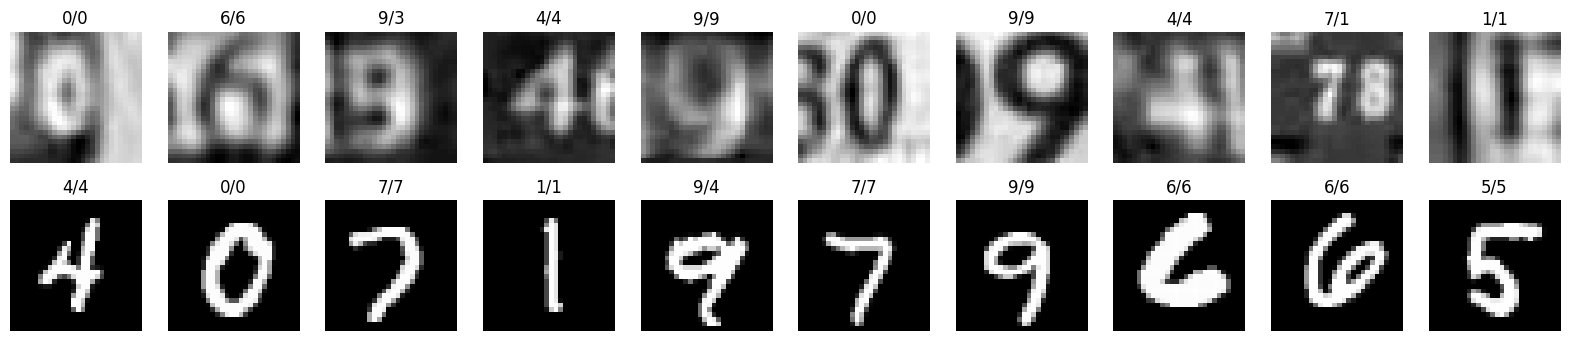

In [80]:
x_example_svhn, y_example_svhn = next(iter(test_loader2))
x_example_svhn, y_example_svhn = x_example_svhn[:20], y_example_svhn[:20]

x_example_mnist, y_example_mnist = next(iter(test_loader))
x_example_mnist, y_example_mnist = x_example_mnist[:20], y_example_mnist[:20]

y_hat_svhn = torch.argmax(torch.softmax(classifier(x_example_svhn.to(device))[0], dim=1), dim=1)
y_hat_mnist = torch.argmax(torch.softmax(classifier(x_example_mnist.to(device))[0], dim=1), dim=1)
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0,i].imshow(x_example_svhn[i].squeeze().numpy(), cmap='gray')
    ax[0,i].set_title(f"{y_example_svhn[i].item()}/{y_hat_svhn[i].item()}")
    ax[0,i].axis('off')
for i in range(10):
    ax[1,i].imshow(x_example_mnist[i].squeeze().numpy(), cmap='gray')
    ax[1,i].set_title(f"{y_example_mnist[i].item()}/{y_hat_mnist[i].item()}")
    ax[1,i].axis('off')

In [45]:
# save the classifier model
# torch.save(classifier.state_dict(), '../notebooks/pretrained/classifier.pt')

In [94]:
def gaussian_wd(m1, s1, m2, s2):
    """
    Computes the Wasserstein distance between two Gaussians
    """
    return (m1 - m2).norm(2) + (s1 - s2).pow(2).sum()

def batch_gaussian_wd(m1, s1, m2, s2):
    """
    Computes the Wasserstein distance between two batches of Gaussians
    """
    mean_sq_norm = (m1.unsqueeze(1) - m2.unsqueeze(0)).norm(2, dim=2)
    stddev_froeb_norm = (s1.unsqueeze(1) - s2.unsqueeze(0)).pow(2).sum(dim=2)
    return mean_sq_norm + stddev_froeb_norm

In [96]:
h_svhn = classifier.encoder(x_example_svhn.to(device))
h_mnist = classifier.encoder(x_example_mnist.to(device))
z_mu_svhn, z_sigma_svhn = ut.gaussian_parameters(h_svhn)
z_mu_mnist, z_sigma_mnist = ut.gaussian_parameters(h_mnist)

# compute the wasserstein distance between each pair of latent representations
# for i in range(10):
#     wd_i = []
#     wd_max = 1e5
#     for j in range(10):
#         print(f"WD between {i} and {j}: {gaussian_wd(z_mu_svhn[i], z_sigma_svhn[i], z_mu_mnist[j], z_sigma_mnist[j]).item()}")
#         wd_ij = gaussian_wd(z_mu_svhn[i], z_sigma_svhn[i], z_mu_mnist[j], z_sigma_mnist[j]).item()
#         if wd_ij < wd_max:
#             j_max = j
#             wd_max = wd_ij
#     print(f"Closest match for {i}: {j_max}, with WD {wd_max}")
wds = batch_gaussian_wd(z_mu_svhn, z_sigma_svhn, z_mu_mnist, z_sigma_mnist)
torch.argmin(wds, dim=1)

tensor([ 6, 17,  6, 12, 14, 16,  7,  6,  4,  3, 16, 10,  6, 17, 14,  6, 10, 14,
        18, 18])

In [108]:
from scipy.optimize import linear_sum_assignment

def optimal_WD_matching(x0, x1, encoder, return_indices=False):
    h0 = encoder(x0.to(device))
    h1 = encoder(x1.to(device))
    z_mu0, z_sigma0 = ut.gaussian_parameters(h0)
    z_mu1, z_sigma1 = ut.gaussian_parameters(h1)
    wds = batch_gaussian_wd(z_mu0, z_sigma0, z_mu1, z_sigma1)
    indices = linear_sum_assignment(wds.cpu().detach().numpy())[1]
    if return_indices:
        return x1[indices], indices
    else:
        return x1[indices]

x_example_svhn, y_example_svhn = next(iter(test_loader2))
x_example_svhn, y_example_svhn = x_example_svhn[:20], y_example_svhn[:20]

x_example_mnist, y_example_mnist = next(iter(test_loader))
x_example_mnist, y_example_mnist = x_example_mnist[:20], y_example_mnist[:20]

x_example_mnist = optimal_WD_matching(x_example_svhn, x_example_mnist, classifier.encoder)

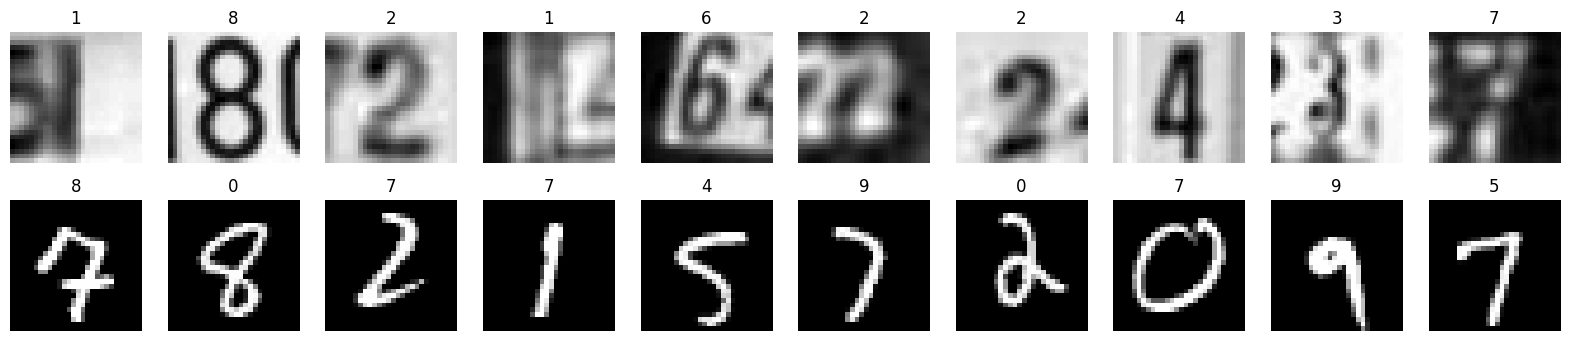

In [109]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0,i].imshow(x_example_svhn[i].squeeze().numpy(), cmap='gray')
    ax[0,i].set_title(f"{y_example_svhn[i].item()}")
    ax[0,i].axis('off')
for i in range(10):
    ax[1,i].imshow(x_example_mnist[i].squeeze().numpy(), cmap='gray')
    ax[1,i].set_title(f"{y_example_mnist[i].item()}")
    ax[1,i].axis('off')

In [110]:
combined_dataloader = ut.get_doubleloader_mnist_and_svhn_data()

Using downloaded and verified file: data/extra_32x32.mat


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    dim = 28,
    dim_mults = (1,2,4),
    flash_attn = True,
    channels=1,
    resnet_block_groups=4,
    attn_dim_head=32,
    attn_heads=2,
).to(device)

# model = SmallNet(dim=28).to(device)

si = EncoderDecoderInterpolant(model)
si = make_sinsq_noisy(si, )

In [28]:
num_params = [p.numel() for p in model.parameters()]
print('Number of parameters: ', sum(num_params))

Number of parameters:  1916769


The training procedure produces trajectories like this:

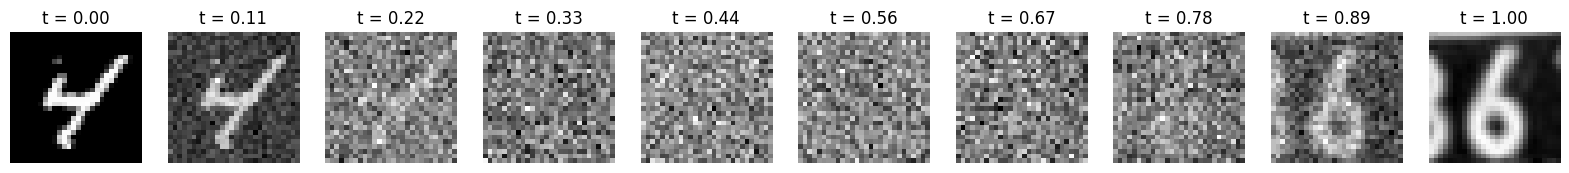

In [29]:
x0_example = next(iter(combined_dataloader))[0][0]
x1_example = next(iter(combined_dataloader))[1][0]

n_steps = 10
t_example = torch.linspace(0, 1, n_steps)

fig, ax = plt.subplots(1,n_steps, figsize=(20, 4))
ax = ax.flatten()

# for i, t in enumerate(t_example):
#     ax[i] = plt.imshow(si.I(t, x0_example, x1_example, ).squeeze().detach().cpu().numpy(), cmap='gray')
#     break

for i, t in enumerate(t_example):
    ax[i].imshow(si.simulate(t, x0_example, x1_example, )[0].squeeze().detach().cpu().numpy(), cmap='gray')
    ax[i].set_title(f't = {t:.2f}')
    ax[i].axis('off')

In [30]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1
si.train(combined_dataloader, optimizer, epochs,loss_type='velocity', eval_int=1, save_int=1, save_path='../notebooks/pretrained/demo_two_sided')

100%|██████████| 600/600 [06:18<00:00,  1.58it/s]

tr @ epoch 1/1 | Loss 1.027508 | 378.71 (s)


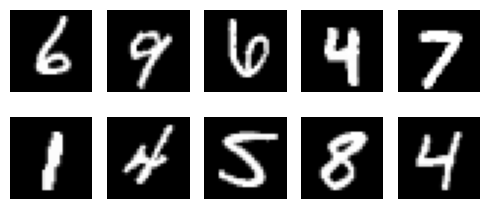

In [31]:
x_initial = next(iter(combined_dataloader))[0][:10].to(device).squeeze()
# show the image
fig, ax = plt.subplots(2, 5, figsize=(5,2.5))
ax = ax.flatten()
for i, img in enumerate(x_initial):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [32]:
# class eta_to_b_model(torch.nn.Module):
#     def __init__(self, si):
#         super().__init__()
#         self.eta = si.model
#         self.a = si.a
#         self.b = si.b
#         self.da = si.da
#         self.db = si.db
#     def forward(self, t,x):
#         if t.dim() == 0:
#             t = t.unsqueeze(-1)
        
#         eta_out = self.eta(t,x)
#         return self.da(t)*eta_out + self.db(t)/self.b(t)*(x - self.a(t)* eta_out)

# b_model = eta_to_b_model(si)

In [33]:
# imgs = b_model(t=torch.tensor([0.001]) , x=x_initial)
# # show the image
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# for i, img in enumerate(imgs):
#     ax[i].imshow(img.squeeze().detach().numpy(), cmap='gray')
#     ax[i].axis('off')

In [34]:
class rvrs_model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        if t.dim() == 0:
            t = t.unsqueeze(-1)
        return - self.model(t, x)

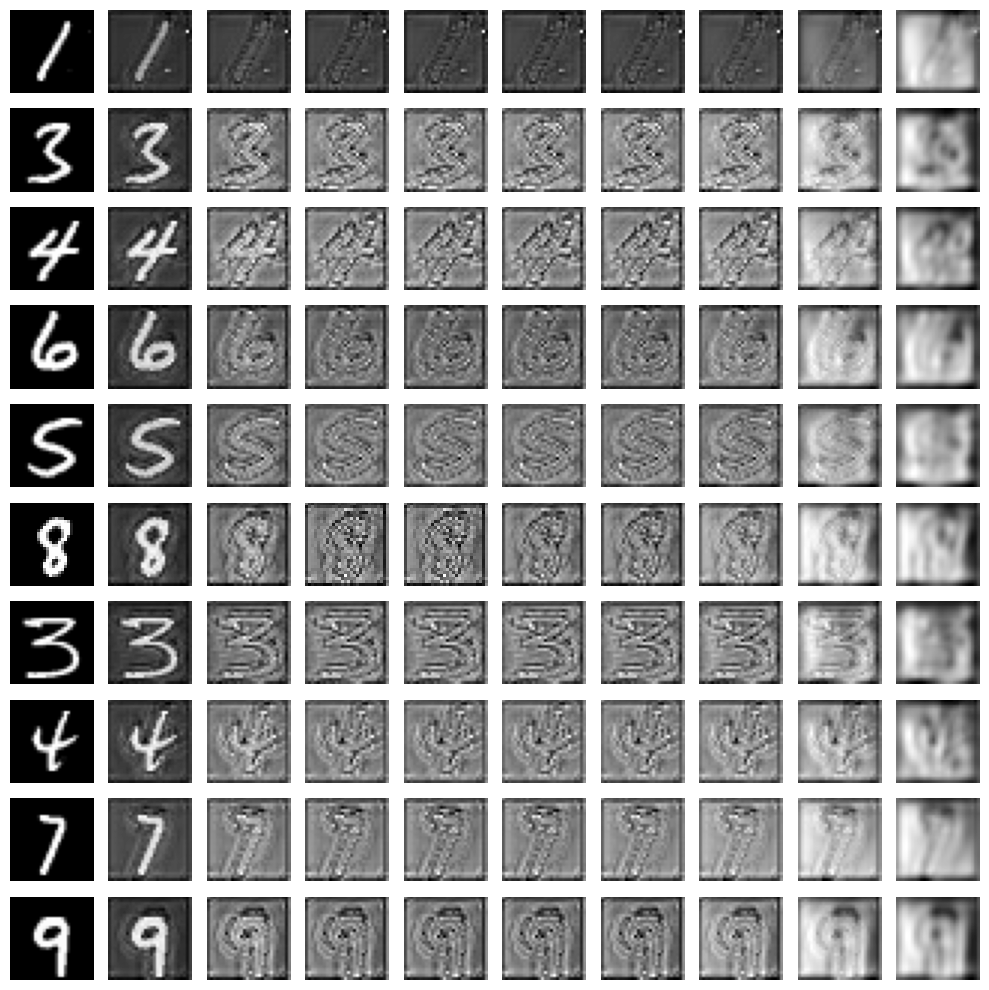

In [35]:
x_initial = next(iter(combined_dataloader))[0][:10].to(device)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(0,1, n_eval, device=device)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(model, x_initial, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()


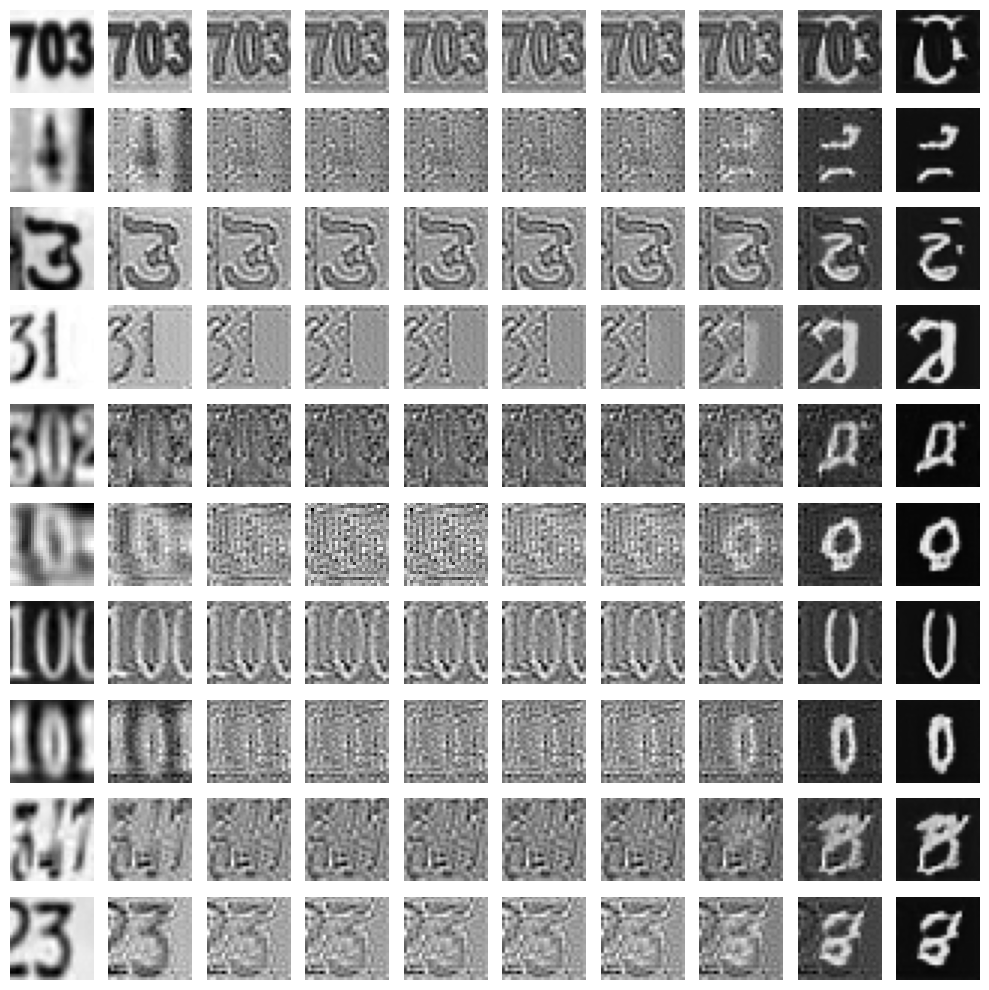

In [41]:
x_initial = next(iter(combined_dataloader))[1][:10].to(device)
# x_initial = torch.randn(10, 1, 28, 28).to(device)

reverse_model = rvrs_model(model)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(1,-0., n_eval, device=device)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-6
atol = 1e-6
out = odeint(model, x_initial, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()